In [1]:
import numpy as np
from scipy import stats

from cobaya.theory import Theory
from cobaya.run import run
from cobaya.log import LoggedError

In [2]:
rng = np.random.default_rng(12345)
# pert_order = rng.integers(low=4, high=6, size=1)


poly_truth = np.polynomial.Polynomial([0.1,-0.2,0.3])


In [3]:
n_samples = 3
sample_points = np.linspace(0,1,num=n_samples)
samples_truth = poly_truth(sample_points)
sample_std_dev = 0.5
sample_noise = rng.normal(0, sample_std_dev, n_samples)
sample_observed = samples_truth+sample_noise

In [4]:
model_dim  =  3
model_keys =  tuple('q'+str(i) for i in range(model_dim))
model_ranges = dict((k,(-1,1)) for k in model_keys)



In [5]:
exec("def noisy_data_logp(" + ",".join(model_keys) + "): return stats.multivariate_normal.logpdf(get_polynomial_vals(" + ",".join(model_keys) + "), mean=samples_truth, cov=sample_std_dev)")

exec("def get_polynomial_vals(" + ",".join(model_keys) + "): return np.polynomial.Polynomial(["+",".join(model_keys)+"])(sample_points)")


In [6]:
likelihood_info = {'noisy_data_like': noisy_data_logp}
params_info = {**{k: {"prior": {"min": -1, "max": 1}} for k in model_keys}}
sampler_info = {'mcmc':{'Rminus1_stop': 0.001}}
info = {'likelihood':likelihood_info,
        'params':params_info,
        'sampler':sampler_info}

In [7]:
updated_info, sampler = run(info)

[noisy_data_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {noisy_data_like: 7260.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: q0:-0.1151408, q1:-0.3292392, q2:-0.7487458
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-25 13:13:18 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.492
[mcmc]  - Convergence of means: R-1 = 0.517877 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] 

In [35]:
exec("def get_polynomial_vals(" + ",".join(model_keys) + "): return np.polynomial.Polynomial(["+",".join(model_keys)+"])(sample_points)")

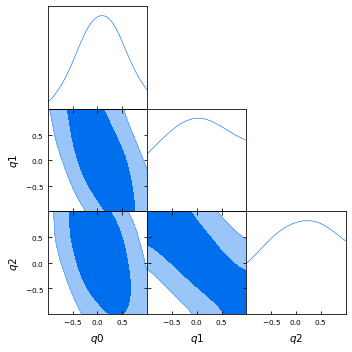

In [8]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, model_keys, filled=True)

In [ ]:
def noisy_data_logp(polynomial_vals):
    """
    Defines multivariate normal distribution for n_samples of data
    with standard deviation of the noise and mean of the observed data.
    """
    return stats.multivariate_normal.logpdf(polynomial_vals, mean=samples_truth, cov=sample_std_dev)

exec("def get_polynomial_vals(" + ",".join(model_keys) + "): return np.polynomial.Polynomial(["+",".join(model_keys)+"])(sample_points)")


likelihood_info = {'noisy_data_like': noisy_data_logp}
params_info = {**{k: {"prior": {"min": -1, "max": 1},"drop":True} for k in model_keys},
              'polynomial_vals':
                  {'value':get_polynomial_vals,'derived':False}}
sampler_info = {'mcmc':{'Rminus1_stop': 0.001}}
info = {'likelihood':likelihood_info,
        'params':params_info,
        'sampler':sampler_info}